In [24]:
!pip install stable-baselines3[extra] gym matplotlib -q

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

In [66]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)


def display_grid(env, state):
    grid = np.array(env.desc, dtype=str)
    row, col = state // env.ncol, state % env.ncol
    grid[row][col] = 'A'
    for r in grid:
        print(' '.join(r))


action_names = {
    0: "Left",
    1: "Down",
    2: "Right",
    3: "Up"
}


def run_agent_with_visualization(env, policy_net, num_episodes=3):
    for i_episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        print(f"Episode {i_episode + 1}")
        display_grid(env, state)
        for t in range(100):
            state_one_hot = np.eye(n_state)[state]
            action = policy_net(torch.FloatTensor(state_one_hot)).max(0)[1].view(1, 1).item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            print(f"Step {t + 1}: Action {action} ({action_names[action]}) - Reward: {reward}")
            display_grid(env, next_state)
            if done:
                print(f"Episode completed. Total Reward: {episode_reward}")
                break
            state = next_state
        print("-" * 30)

In [61]:
learning_rate = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
batch_size = 64
buffer_size = 10000
min_buffer_size = 1000
num_episodes = 1000
is_slippery = False

env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
env.reset()
n_state = env.observation_space.n
n_action = env.action_space.n

policy_net = DQN(n_state, n_action)
target_net = DQN(n_state, n_action)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = ReplayBuffer(buffer_size)

def select_action(state, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state)).max(0)[1].view(1, 1).item()
    else:
        return env.action_space.sample()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [62]:
run_agent_with_visualization(env, policy_net, num_episodes=1)

Episode 1
A F F F
F H F H
F F F H
H F F G
Step 1: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 2: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 3: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 4: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 5: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 6: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 7: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 8: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 9: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 10: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 11: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 12: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 13: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 14: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 15: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 16: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 17: Action 3 (Up)
A F F F
F H F H
F F F H
H F F G
Step 18: Action 3 (Up)
A F F F
F

In [63]:
epsilon = epsilon_start
steps_done = 0

episode_rewards = []
running_avg_rewards = []
steps_per_episode = []

for i_episode in range(num_episodes):
    state = env.reset()
    state = np.eye(n_state)[state]
    total_reward = 0
    steps = 0

    for t in range(100):
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        next_state = np.eye(n_state)[next_state]
        memory.push(state, action, reward, next_state, done)
        state = next_state

        if len(memory) > min_buffer_size:
            transitions = memory.sample(batch_size)
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = transitions

            non_final_mask = torch.tensor(tuple(map(lambda s: s is not True, batch_done)), dtype=torch.bool)
            non_final_next_states = torch.FloatTensor([s for s, d in zip(batch_next_state, batch_done) if d is not True])
            state_batch = torch.FloatTensor(batch_state)
            action_batch = torch.LongTensor(batch_action)
            reward_batch = torch.FloatTensor(batch_reward)

            state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
            next_state_values = torch.zeros(batch_size)
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
            expected_state_action_values = (next_state_values * gamma) + reward_batch

            loss = nn.MSELoss()(state_action_values, expected_state_action_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break
        steps += 1

    total_reward += reward
    episode_rewards.append(total_reward)
    running_avg_rewards.append(np.mean(episode_rewards[-100:]))
    steps_per_episode.append(steps)

    epsilon = max(epsilon_end, epsilon_decay * epsilon)
    if i_episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

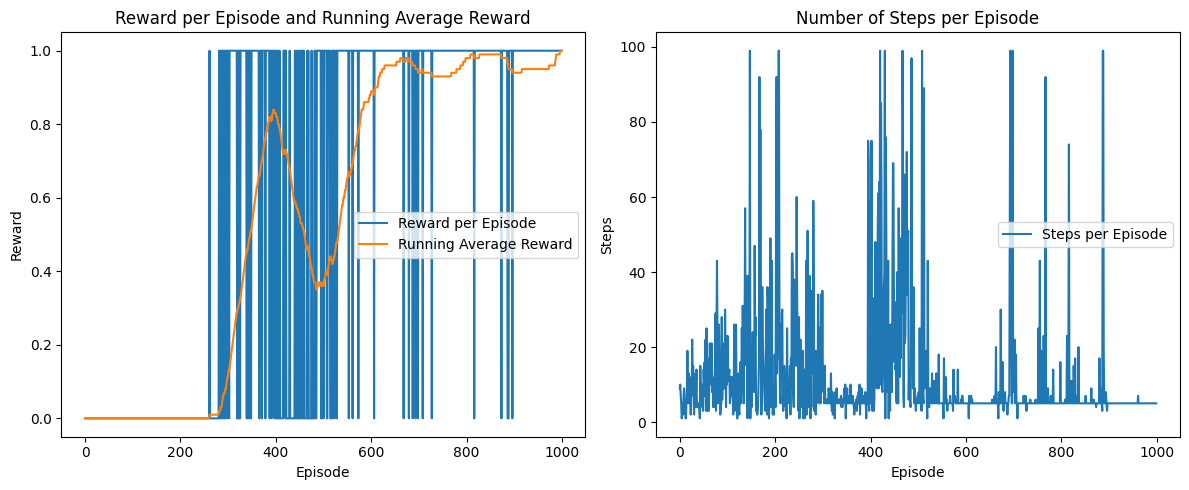

In [64]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards, label='Reward per Episode')
plt.plot(running_avg_rewards, label='Running Average Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode and Running Average Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps_per_episode, label='Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Number of Steps per Episode')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
run_agent_with_visualization(env, policy_net, num_episodes=3)

Episode 1
A F F F
F H F H
F F F H
H F F G
Step 1: Action 2 (Right) - Reward: 0.0
S A F F
F H F H
F F F H
H F F G
Step 2: Action 2 (Right) - Reward: 0.0
S F A F
F H F H
F F F H
H F F G
Step 3: Action 1 (Down) - Reward: 0.0
S F F F
F H A H
F F F H
H F F G
Step 4: Action 1 (Down) - Reward: 0.0
S F F F
F H F H
F F A H
H F F G
Step 5: Action 1 (Down) - Reward: 0.0
S F F F
F H F H
F F F H
H F A G
Step 6: Action 2 (Right) - Reward: 1.0
S F F F
F H F H
F F F H
H F F A
Episode completed. Total Reward: 1.0
------------------------------
Episode 2
A F F F
F H F H
F F F H
H F F G
Step 1: Action 2 (Right) - Reward: 0.0
S A F F
F H F H
F F F H
H F F G
Step 2: Action 2 (Right) - Reward: 0.0
S F A F
F H F H
F F F H
H F F G
Step 3: Action 1 (Down) - Reward: 0.0
S F F F
F H A H
F F F H
H F F G
Step 4: Action 1 (Down) - Reward: 0.0
S F F F
F H F H
F F A H
H F F G
Step 5: Action 1 (Down) - Reward: 0.0
S F F F
F H F H
F F F H
H F A G
Step 6: Action 2 (Right) - Reward: 1.0
S F F F
F H F H
F F F H
H F F A
Ep